# Multiple output from LSTM Model

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import warnings
from keras.models import Sequential # type: ignore
from keras.layers import Dense, LSTM # type: ignore
from sklearn.preprocessing import MinMaxScaler

In [20]:
rsrp_colors = ['#384959', '#6A89A7', '#88BDF2', '#BDDDFC']
rsrq_colors = ['#614419', '#B37E2E', '#DB9A39', '#FFB343']
sinr_colors = ['#135E4B', '#4CB572', '#A1D8B5', '#CCDCDB']
mode_colors = ['#872323', '#C93636', '#E26666', '#F4B6B6']

### Prossessing functions

In [21]:
'''
    Reading the dataset and returning two pandas DataFrames:
        The first DataFrame containing every datapoint belonging to the given campaign (if any)
        The second DataFrame containing only one column - the mode (4G or 5G)
'''
def read_dataset(filename, campaigns=None, features=None):
    df = pd.read_csv(filename)
    df = df.loc[:, ~df.columns.str.match('Unnamed')]
    df = df.loc[:, ~df.columns.str.match('Timestamp')]
    df = df.replace('DC', 1)
    df = df.replace('LTE', 0)
    df = df[df['campaign'].str.contains('Driving') | df['campaign'].str.contains('Walking')]

    if campaigns != None:
        df = df[df['campaign'].isin(campaigns)]

    if features == None:
        features = ['RSRP', 'SINR', 'RSRQ', 'SSS_RSRP', 'SSS_SINR', 'SSS_RSRQ', 'campaign']

    features.append('Mode')
    features.append('Latitude')
    features.append('Longitude')
    return df[features]

### LSTM functions

In [22]:
'''
    Returns a numpy array of list 
'''
def series_split_sequences(f, t, n_steps_in, n_steps_out):
    X, y = [], []
    curr_campaign = ''
    for i in range(len(f)):
        # find the end of the pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out

        if out_end_ix > len(f):
            break

        if curr_campaign == '': # set new current campaign if there is no campaign
            curr_campaign = f['campaign'].iloc[i]
        seq_x, seq_y = f[i:end_ix], t[end_ix:out_end_ix]
        if f.iloc[i:out_end_ix]['campaign'].nunique() > 1: # check to see if in transition between two campaigns
            continue
        elif curr_campaign != f['campaign'].iloc[i]: # set new campaign equal to current if this is the campaign we are looping through
            curr_campaign = f['campaign'].iloc[i]
        X.append(seq_x.drop('campaign', axis=1))
        y.append(seq_y)

    return np.array(X), np.array(y)


'''
    Returns the mean absolute error on each datapoint
'''
def single_point_mae(y_pred, y_true):
    pred_series, true_series = [], []
    mae_list = []

    for i in range(len(y_pred)):
        mae = []
        for k in range(len(y_pred[i])):
            pred_series.append(y_pred[i][k])
            true_series.append(y_true[i][k])
            mae.append(np.abs(y_pred[i][k] - y_true[i][k]))
        mae_list.append(mae)

    pred_series, true_series = np.array(pred_series), np.array(true_series)

    return np.mean(np.abs(pred_series - true_series)), np.array(mae_list)


def long_short_term_memory(train, test, target_feature:str, features:list, campaigns:list, test_campaigns:list, n_steps_in=5, n_steps_out=1, n_first_units=5, n_second_units=10):

    features.remove('campaign')

    idx_target = features.index(target_feature)

    scaler = MinMaxScaler()
    train[features] = scaler.fit_transform(train[features])
    test[features] = scaler.transform(test[features])

    X, y = series_split_sequences(train, train[target_feature], n_steps_in, n_steps_out)
    X_test, y_test = series_split_sequences(test, test[target_feature], n_steps_in, n_steps_out)

    train_idx = 4 * len(y) // 5

    X_train, y_train = X[0 : train_idx], y[0 : train_idx]
    X_val, y_val = X[train_idx ::], y[train_idx ::]

    # optimizer = RMSprop(learning_rate=0.001, rho=0.9) # , epsilon=None) 

    model = Sequential()
    model.add(LSTM(units=n_first_units,
                   activation='relu', recurrent_activation='sigmoid',
                   return_sequences=True, return_state=False
                   ))
    # model.add(Dropout(0.2))
    model.add(LSTM(units=n_second_units,
                   activation='relu', recurrent_activation='sigmoid',
                   return_sequences=False, return_state=False
                   ))
    # model.add(Dropout(0.2))
    model.add(Dense(n_steps_out, activation='sigmoid'))
    model.compile(loss='mse', optimizer='adam')
    
    history = model.fit(X_train, y_train,
              epochs=100,
              validation_data=(X_val, y_val),
              shuffle=True, verbose=0)   

    scaler_pred = MinMaxScaler()
    scaler_pred.min_, scaler_pred.scale_ = scaler.min_[idx_target], scaler.scale_[idx_target]

    y_pred = model.predict(X_test, verbose=0) 

    y_pred = scaler_pred.inverse_transform(y_pred)
    y_true = scaler_pred.inverse_transform(y_test)
    test[features] = scaler.inverse_transform(test[features])

    train_pred = model.predict(X, verbose=0)

    train_pred = scaler_pred.inverse_transform(train_pred)
    train[features] = scaler.inverse_transform(train[features])
    _, test_y_seq = series_split_sequences(train, train[target_feature], n_steps_in, n_steps_out)
        
    mae = single_point_mae(y_pred, y_true)
    train_mae = single_point_mae(train_pred, test_y_seq)

    results = {'y_pred': y_pred,
               'y_true': y_true,
               'train_pred': train_pred,
               'train_true': y_train,
               'loss' : history.history['loss'],
               'loss_final' : round(history.history['loss'][-1], 5),
               'val_loss' : history.history['val_loss'],
               'val_loss_final' : round(history.history['val_loss'][-1], 5),
               'mae': round(mae[0], 2),
               'list_mae': mae[1],
               'train_mae': round(train_mae[0], 2),
               'train_list_mae': train_mae[1]
               }

    return results


'''
    Plots the mean absolute errors in a boxplot for each signal strength indicator
    Returns a dataframe with mean mae for each timestep for each signal strength indicator
'''
def boxplot_timesteps(results:dict, feature_comb:list, sss_feature_comb:list, n_steps_out:int, operator:str, whiskers=[5, 95], y_lim=None):
    selected_rsrp, selected_sinr, selected_rsrq = feature_comb[0], feature_comb[1], feature_comb[2]
    selected_sss_rsrp, selected_sss_sinr, selected_sss_rsrq = sss_feature_comb[0], sss_feature_comb[1], sss_feature_comb[2]

    rsrp_lstm, sinr_lstm, rsrq_lstm = results[selected_rsrp]['list_mae'], results[selected_sinr]['list_mae'], results[selected_rsrq]['list_mae']
    sss_rsrp_lstm, sss_sinr_lstm, sss_rsrq_lstm = results[selected_sss_rsrp]['list_mae'], results[selected_sss_sinr]['list_mae'], results[selected_sss_rsrq]['list_mae']

    rsrp_lstm_mae, sinr_lstm_mae, rsrq_lstm_mae, sss_rsrp_lstm_mae, sss_sinr_lstm_mae, sss_rsrq_lstm_mae = [], [], [], [], [], []
    mean_rsrp, mean_sinr, mean_rsrq, mean_sss_rsrp, mean_sss_sinr, mean_sss_rsrq = [], [], [], [], [], []

    for i in range(n_steps_out):
        rsrp_lstm_mae.append(rsrp_lstm[:, i])
        mean_rsrp.append(round(np.mean(rsrp_lstm[:, i]), 3))

        sinr_lstm_mae.append(sinr_lstm[:, i])
        mean_sinr.append(round(np.mean(sinr_lstm[:, i]), 3))

        rsrq_lstm_mae.append(rsrq_lstm[:, i])
        mean_rsrq.append(round(np.mean(rsrq_lstm[:, i]), 3))

        sss_rsrp_lstm_mae.append(sss_rsrp_lstm[:, i])
        mean_sss_rsrp.append(round(np.mean(sss_rsrp_lstm[:, i]), 3))

        sss_sinr_lstm_mae.append(sss_sinr_lstm[:, i])
        mean_sss_sinr.append(round(np.mean(sss_sinr_lstm[:, i]), 3))

        sss_rsrq_lstm_mae.append(sss_rsrq_lstm[:, i])
        mean_sss_rsrq.append(round(np.mean(sss_rsrq_lstm[:, i]), 3))
    
    labels = ['1st', '2nd', '3rd', '4th', '5th', '6th', '7th', '8th', '9th', '10th', '11th', '12th', '13th', '14th', '15th', '16th', '17th', '18th', '19th', '20th']

    fig, axes = plt.subplots(2, 3, figsize=(18, 12), sharey=True)
    sns.boxplot(data=rsrp_lstm_mae, color=rsrp_colors[2], ax=axes[0, 0], whis=whiskers)
    axes[0, 0].set_title('Mean absolute errors of RSRP')

    sns.boxplot(data=sinr_lstm_mae, color=sinr_colors[2], ax=axes[0, 1], whis=whiskers)
    axes[0, 1].set_title('Mean absolute errors of SINR')

    sns.boxplot(data=rsrq_lstm_mae, color=rsrq_colors[2], ax=axes[0, 2], whis=whiskers)
    axes[0, 2].set_title('Mean absolute errors of RSRQ')

    sns.boxplot(data=sss_rsrp_lstm_mae, color=rsrp_colors[2], ax=axes[1, 0], whis=whiskers)
    axes[1, 0].set_title('Mean absolute errors of SSS-RSRP')

    sns.boxplot(data=sss_sinr_lstm_mae, color=sinr_colors[2], ax=axes[1, 1], whis=whiskers)
    axes[1, 1].set_title('Mean absolute errors of SSS-SINR')

    sns.boxplot(data=sss_rsrq_lstm_mae, color=rsrq_colors[2], ax=axes[1, 2], whis=whiskers)
    axes[1, 2].set_title('Mean absolute errors of SSS-RSRQ')

    axes[0, 0].set_ylim((-0.2, y_lim))

    for ax in axes.flat:
        ax.set_ylabel('Mean Absolute Error')
        ax.set_xlabel('Timestep')
        ax.set_xticks(range(n_steps_out))
        ax.set_xticklabels(labels[0:n_steps_out])
        
    plt.suptitle(f'{n_steps_out} Timesteps Ahead -- {operator}', fontsize=16, fontweight='semibold')

    plt.show()

    means = {
        'RSRP': mean_rsrp,
        'SINR': mean_sinr,
        'RSRQ': mean_rsrq,
        'SSS-RSRP': mean_sss_rsrp,
        'SSS-SINR': mean_sss_sinr,
        'SSS-RSRQ': mean_sss_rsrq
    }

    means = pd.DataFrame(means, index=labels[0:n_steps_out]).T

    return means

### Random Forest functions

In [23]:
def rf(X_train, X_test, mode_train, mode_test, campaigns, test_campaigns, features, n_estimators=100, max_depth=None, min_samples_leaf=1):
    permutation = np.random.permutation(X_train.index)
    X_train_randomized = X_train.reindex(permutation).reset_index(drop=True)
    mode_train_randomized = mode_train.reindex(permutation).reset_index(drop=True)

    rf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, min_samples_leaf=min_samples_leaf)
    smote = SMOTE()
    # rus = RandomUnderSampler() 
    X_train_balanced, mode_train_balanced = smote.fit_resample(X_train_randomized[features], mode_train_randomized['Mode'])
    # X_train_balanced, mode_train_balanced = rus.fit_resample(X_train_balanced, mode_train_balanced)

    rf.fit(X_train_balanced, mode_train_balanced)

    if len(test_campaigns) == 1:
        y_pred = rf.predict(X_test[features])

        accuracy = accuracy_score(mode_test['Mode'], y_pred)
        precision = precision_score(mode_test['Mode'], y_pred)
        recall = recall_score(mode_test['Mode'], y_pred)

        y_true = mode_test['Mode']

        

        train_pred = rf.predict(X_train[features])

        train_accuracy = accuracy_score(mode_train['Mode'], train_pred)
        train_precision = precision_score(mode_train['Mode'], train_pred)
        train_recall = recall_score(mode_train['Mode'], train_pred)

        train_true = mode_train['Mode']
    else:
        X_test_test = X_test[X_test['campaign'] == test_campaigns[0]]
        X_test_mode = mode_test[mode_test['campaign'] == test_campaigns[0]]
        
        y_pred = rf.predict(X_test_test[features])

        y_pred_total = rf.predict(X_test[features])
        accuracy = accuracy_score(mode_test['Mode'], y_pred_total)
        precision = precision_score(mode_test['Mode'], y_pred_total)
        recall = recall_score(mode_test['Mode'], y_pred_total)

        y_true = X_test_mode['Mode']

        X_train_test = X_train[X_train['campaign'] == campaigns[0]]
        X_train_mode = mode_train[mode_train['campaign'] == campaigns[0]]

        train_pred = rf.predict(X_train_test[features])

        train_pred_total = rf.predict(X_train[features])
        train_accuracy = accuracy_score(mode_train['Mode'], train_pred_total)
        train_precision = precision_score(mode_train['Mode'], train_pred_total)
        train_recall = recall_score(mode_train['Mode'], train_pred_total)

        train_true = X_train_mode['Mode']

    results = {'Accuracy': round(accuracy, 3),
               'Precision': round(precision, 3),
               'Recall': round(recall, 3),
               'y_true' : y_true,
               'y_pred' : y_pred,
               'train_true': train_true,
               'train_pred': train_pred,
               'Accuracy_train': round(train_accuracy, 3),
               'Precision_train': round(train_precision, 3),
               'Recall_train': round(train_recall, 3),
               'model': rf}
    return results

### Overlapping campaigns

* Ping_UNIDATA_4G5G_TIM_Driving_Viale_Marconi, Ping_UNIDATA_4G5G_TIM_Driving_Viale_Marconi_Test_2_No_Flight_Mode, Ping_UNIDATA_4G5G_TIM_Driving_Palasport_to_Via_Appia_End_No_Flight_Mode, Interactivity_gaming_4G5G_TIM_Driving_Viale_Marconi_No_Flight_Mode, Interactivity_gaming_4G5G_TIM_Driving_Palasport_to_Via_Appia_End_No_Flight_Mode, Capacity_Ookla_UNIDATA_4G5G_TIM_Driving_Viale_Marconi

* Ping_UNIDATA_4G5G_TIM_Walking_Termini_to_DIET, Ping_UNIDATA_4G5G_TIM_Walking_DIET_to_Termini, Ping_UNIDATA_4G5G_TIM_Walking_DIET_to_Labicana_Hotel, Interactivity_gaming_4G5G_TIM_Walking_Termini_to_DIET_Test_2_No_Flight_Mode, Capacity_Ookla_UNIDATA_4G5G_TIM_Walking_DIET_to_Labicana_Hotel

* Ping_UNIDATA_4G5G_TIM_Walking_Tuscolana_Stat_Appia, Ping_UNIDATA_4G5G_TIM_Walking_Tuscolana_Stat_Appia_Part_2, Interactivity_gaming_4G5G_TIM_Driving_Tuscolana_Stat_Appia_No_Flight_Mode, Capacity_Ookla_UNIDATA_4G5G_TIM_Walking_Tuscolana_Stat_Appia, Capacity_Ookla_4G5G_TIM_Driving_Tuscolana_Stat_Appia_No_Flight_Mode

* Ping_UNIDATA_4G5G_TIM_Driving_Luca, Interactivity_gaming_4G5G_TIM_Driving_Luca, Capacity_Ookla_4G5G_Tim_Driving_Luca

### Parameters

In [24]:
tf.random.set_seed(4567)

# LSTM
n_steps_in = 5
n_steps_out = 1

n_first_units = 5
n_second_units = 10

# Random Forest
n_estimators = 100
min_leaf_size = 5

In [25]:
overlap_1 = ['Ping_UNIDATA_4G5G_TIM_Driving_Viale_Marconi_Test_2_No_Flight_Mode',
             'Ping_UNIDATA_4G5G_TIM_Driving_Viale_Marconi', 
             'Interactivity_gaming_4G5G_TIM_Driving_Viale_Marconi_No_Flight_Mode', 
             'Capacity_Ookla_UNIDATA_4G5G_TIM_Driving_Viale_Marconi',
             'Interactivity_gaming_4G5G_TIM_Driving_Palasport_to_Via_Appia_End_No_Flight_Mode',
             'Ping_UNIDATA_4G5G_TIM_Driving_Palasport_to_Via_Appia_End_No_Flight_Mode']

overlap_2 = ['Ping_UNIDATA_4G5G_TIM_Walking_Termini_to_DIET', 
             'Ping_UNIDATA_4G5G_TIM_Walking_DIET_to_Termini', 
             'Ping_UNIDATA_4G5G_TIM_Walking_DIET_to_Labicana_Hotel', 
             'Interactivity_gaming_4G5G_TIM_Walking_Termini_to_DIET_Test_2_No_Flight_Mode', 
             'Capacity_Ookla_UNIDATA_4G5G_TIM_Walking_DIET_to_Labicana_Hotel']

overlap_3 = ['Ping_UNIDATA_4G5G_TIM_Walking_Tuscolana_Stat_Appia', 
             'Ping_UNIDATA_4G5G_TIM_Walking_Tuscolana_Stat_Appia_Part_2', 
             'Interactivity_gaming_4G5G_TIM_Driving_Tuscolana_Stat_Appia_No_Flight_Mode', 
             'Capacity_Ookla_UNIDATA_4G5G_TIM_Walking_Tuscolana_Stat_Appia', 
             'Capacity_Ookla_4G5G_TIM_Driving_Tuscolana_Stat_Appia_No_Flight_Mode']

overlap_4 = ['Ping_UNIDATA_4G5G_TIM_Driving_Luca', 
             'Interactivity_gaming_4G5G_TIM_Driving_Luca', 
             'Capacity_Ookla_4G5G_Tim_Driving_Luca']

In [26]:
train = read_dataset('datasets/Op1_merged.csv', campaigns=[overlap_1[1]])
test = read_dataset('datasets/Op1_merged.csv', campaigns=[overlap_1[0]])
operator = 'Operator 1'

## 2 Steps prediction

In [27]:
target_features = ['RSRP', 'SINR', 'RSRQ', 'SSS_RSRP', 'SSS_SINR', 'SSS_RSRQ']
feature_selection = [#['RSRP'], ['SINR'], ['RSRQ'], 
                    #  ['RSRP', 'SINR'], ['RSRP', 'RSRQ'], ['SINR', 'RSRQ'], 
                     ['RSRP', 'SINR', 'RSRQ'],
                     #['SSS_RSRP'], ['SSS_SINR'], ['SSS_RSRQ'],
                    #  ['SSS_RSRP', 'SSS_SINR'], ['SSS_RSRP', 'SSS_RSRQ'], ['SSS_SINR', 'SSS_RSRQ'], 
                     ['SSS_RSRP', 'SSS_SINR', 'SSS_RSRQ'],
                    #  ['RSRP', 'SSS_RSRP'], ['SINR', 'SSS_SINR'], ['RSRQ', 'SSS_RSRQ'], 
                     ['RSRP', 'SINR', 'RSRQ', 'SSS_RSRP', 'SSS_SINR', 'SSS_RSRQ']]

In [28]:
n_steps_in = 2
n_steps_out = 2

lstm_results = {}

for target in target_features:
    for features in feature_selection:
        if features.__contains__(target):
            used_features = ''
            if len(features) == 6:
                used_features = 'All'
            else:
                used_features = ', '.join(features)
            used_features = used_features + ' -> ' + target
            features.append('campaign')
            warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)
            lstm_results[used_features] = long_short_term_memory(train=train[features], test=test[features], target_feature=target, features=features, n_steps_in=n_steps_in, n_steps_out=n_steps_out, campaigns=train['campaign'].unique().tolist(), test_campaigns=test['campaign'].unique().tolist(), n_first_units=n_first_units, n_second_units=n_second_units)
            df_lstm_results = pd.DataFrame.from_dict(lstm_results, orient='index')

df_lstm_results.reset_index(inplace=True)
df_lstm_results.rename(columns={'index': 'Combination'}, inplace=True)
df_lstm_results = df_lstm_results.drop(['y_pred', 'y_true', 'train_pred', 'train_true', 'loss', 'val_loss', 'list_mae', 'train_list_mae'], axis=1)
df_lstm_results

,Combination,loss_final,val_loss_final,mae,train_mae
0,"RSRP, SINR, RSRQ -> RSRP",0.00255,0.00235,0.82,1.01
1,All -> RSRP,0.00275,0.00292,1.30,1.44
2,"RSRP, SINR, RSRQ -> SINR",0.00219,0.00370,0.60,1.10
3,All -> SINR,0.00231,0.00262,0.71,1.10
4,"RSRP, SINR, RSRQ -> RSRQ",0.00484,0.00169,0.52,0.57
5,All -> RSRQ,0.00512,0.00203,0.58,0.60
6,"SSS_RSRP, SSS_SINR, SSS_RSRQ -> SSS_RSRP",0.00279,0.00192,1.64,1.43
7,All -> SSS_RSRP,0.00261,0.00194,1.33,1.32
8,"SSS_RSRP, SSS_SINR, SSS_RSRQ -> SSS_SINR",0.00323,0.00251,1.37,1.32
9,All -> SSS_SINR,0.00348,0.00354,1.70,1.60


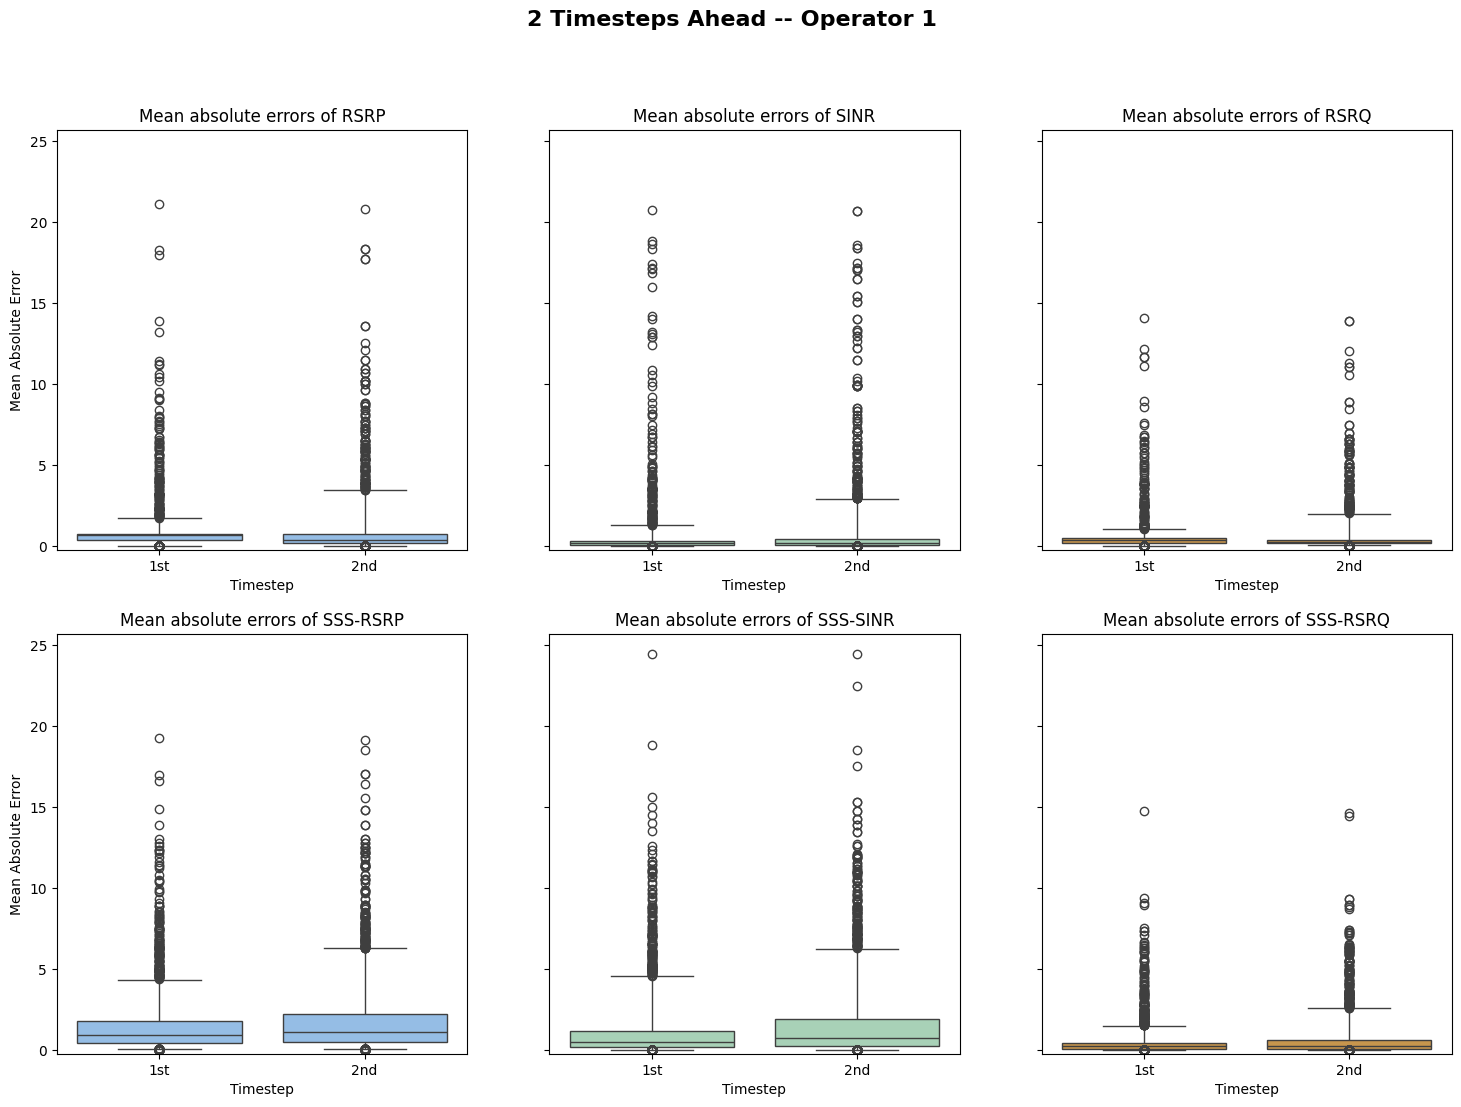

In [29]:
feature_comb = ['RSRP, SINR, RSRQ -> RSRP', 'RSRP, SINR, RSRQ -> SINR', 'RSRP, SINR, RSRQ -> RSRQ']
sss_feature_comb = ['SSS_RSRP, SSS_SINR, SSS_RSRQ -> SSS_RSRP', 'SSS_RSRP, SSS_SINR, SSS_RSRQ -> SSS_SINR', 'SSS_RSRP, SSS_SINR, SSS_RSRQ -> SSS_RSRQ']

mae_each_step = boxplot_timesteps(results=lstm_results, feature_comb=feature_comb, sss_feature_comb=sss_feature_comb, n_steps_out=n_steps_out, operator=operator)

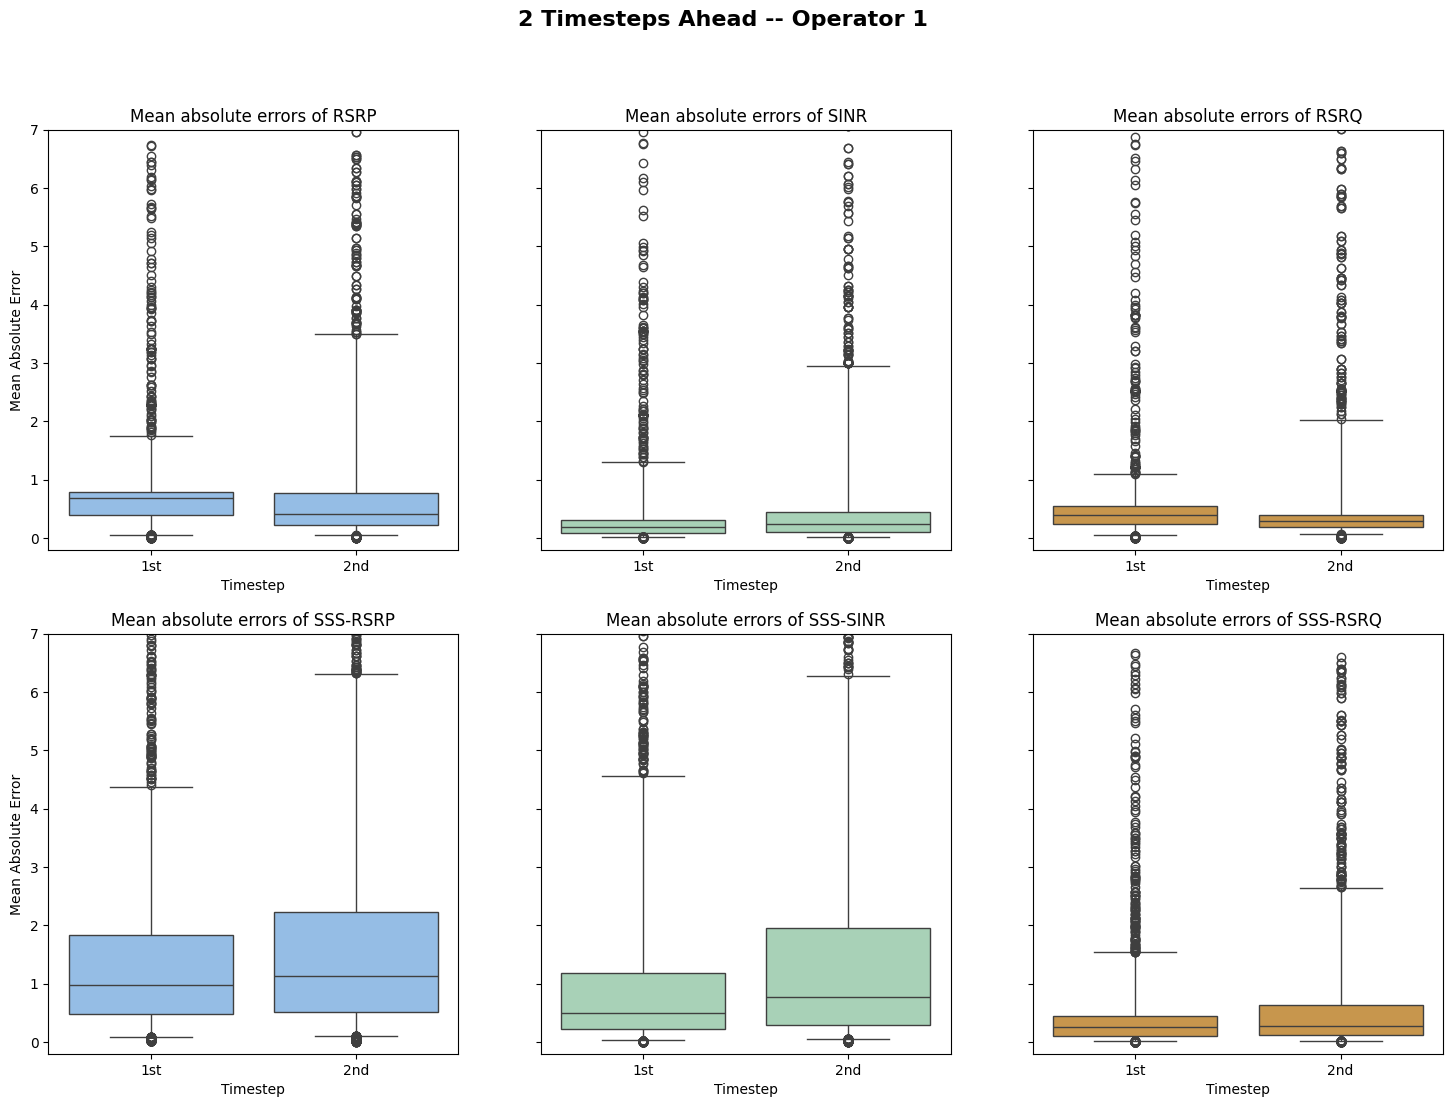

In [31]:
mae_each_step = boxplot_timesteps(results=lstm_results, feature_comb=feature_comb, sss_feature_comb=sss_feature_comb, n_steps_out=n_steps_out, operator=operator, y_lim=7)

In [30]:
mae_each_step

,1st,2nd
RSRP,0.795,0.837
SINR,0.480,0.712
RSRQ,0.509,0.526
SSS-RSRP,1.453,1.835
SSS-SINR,1.111,1.630
SSS-RSRQ,0.458,0.641


## 3 Steps Prediction

In [32]:
n_steps_in = 3
n_steps_out = 3

lstm_results = {}

for target in target_features:
    for features in feature_selection:
        if features.__contains__(target):
            used_features = ''
            if len(features) == 6:
                used_features = 'All'
            else:
                used_features = ', '.join(features)
            used_features = used_features + ' -> ' + target
            features.append('campaign')
            warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)
            lstm_results[used_features] = long_short_term_memory(train=train[features], test=test[features], target_feature=target, features=features, n_steps_in=n_steps_in, n_steps_out=n_steps_out, campaigns=train['campaign'].unique().tolist(), test_campaigns=test['campaign'].unique().tolist(), n_first_units=n_first_units, n_second_units=n_second_units)
            df_lstm_results = pd.DataFrame.from_dict(lstm_results, orient='index')

df_lstm_results.reset_index(inplace=True)
df_lstm_results.rename(columns={'index': 'Combination'}, inplace=True)
df_lstm_results = df_lstm_results.drop(['y_pred', 'y_true', 'train_pred', 'train_true', 'loss', 'val_loss', 'list_mae', 'train_list_mae'], axis=1)
df_lstm_results

,Combination,loss_final,val_loss_final,mae,train_mae
0,"RSRP, SINR, RSRQ -> RSRP",0.00352,0.00397,0.89,1.38
1,All -> RSRP,0.00317,0.00310,0.89,1.18
2,"RSRP, SINR, RSRQ -> SINR",0.00270,0.00375,0.71,1.29
3,All -> SINR,0.00273,0.00328,1.12,1.44
4,"RSRP, SINR, RSRQ -> RSRQ",0.00616,0.00271,0.66,0.71
5,All -> RSRQ,0.00617,0.00213,0.49,0.57
6,"SSS_RSRP, SSS_SINR, SSS_RSRQ -> SSS_RSRP",0.00341,0.00226,1.87,1.63
7,All -> SSS_RSRP,0.00301,0.00197,1.62,1.47
8,"SSS_RSRP, SSS_SINR, SSS_RSRQ -> SSS_SINR",0.00403,0.00367,1.76,1.64
9,All -> SSS_SINR,0.00387,0.00379,1.83,1.65


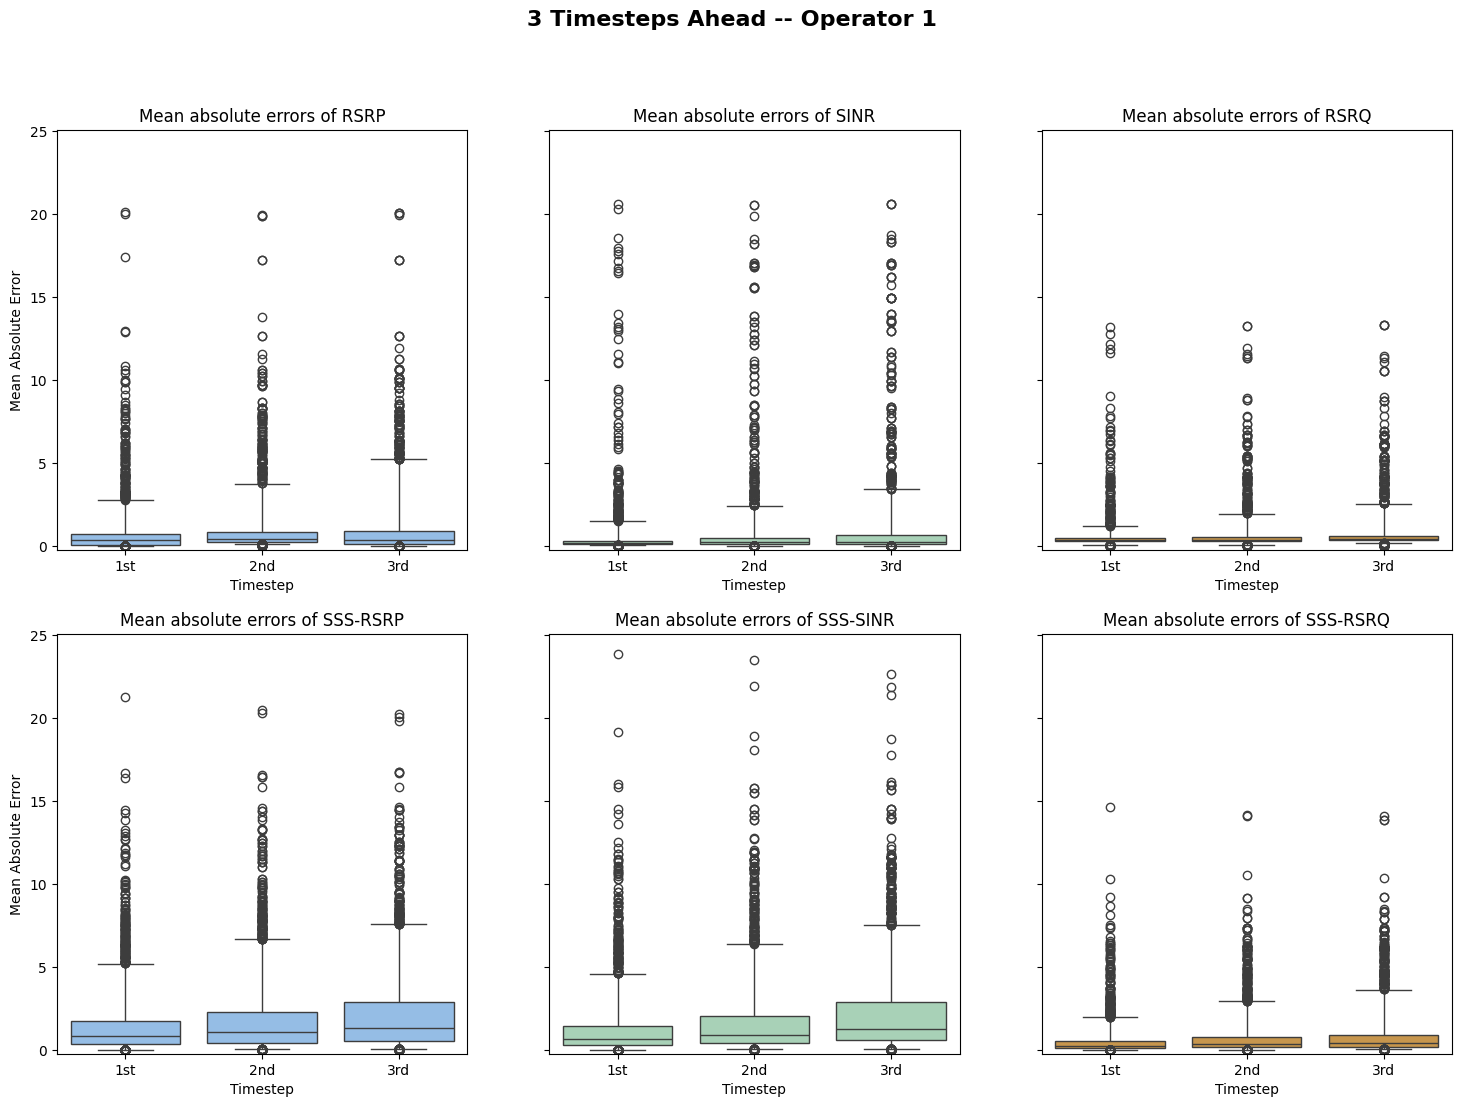

In [33]:
mae_each_step = boxplot_timesteps(results=lstm_results, feature_comb=feature_comb, sss_feature_comb=sss_feature_comb, n_steps_out=n_steps_out, operator=operator)

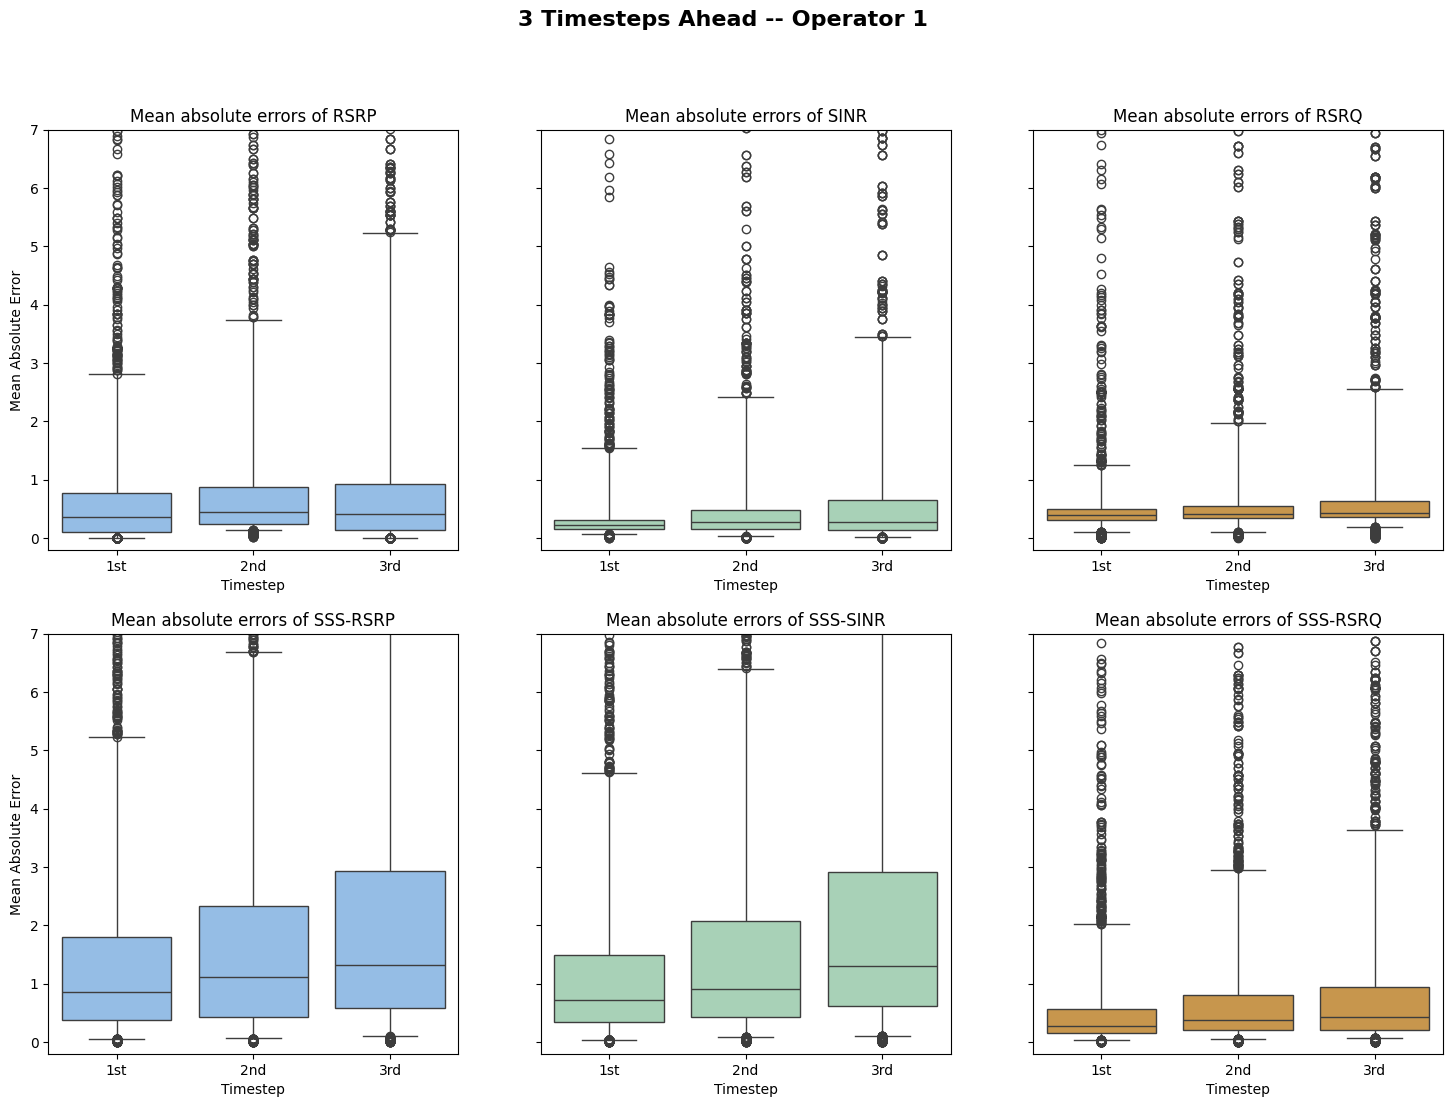

In [34]:
mae_each_step = boxplot_timesteps(results=lstm_results, feature_comb=feature_comb, sss_feature_comb=sss_feature_comb, n_steps_out=n_steps_out, operator=operator, y_lim=7)

In [35]:
mae_each_step

,1st,2nd,3rd
RSRP,0.691,0.946,1.026
SINR,0.505,0.712,0.925
RSRQ,0.545,0.656,0.774
SSS-RSRP,1.485,1.879,2.254
SSS-SINR,1.301,1.754,2.234
SSS-RSRQ,0.552,0.761,0.904


## 5 Steps Prediction

In [36]:
n_steps_in = 5
n_steps_out = 5

lstm_results = {}

for target in target_features:
    for features in feature_selection:
        if features.__contains__(target):
            used_features = ''
            if len(features) == 6:
                used_features = 'All'
            else:
                used_features = ', '.join(features)
            used_features = used_features + ' -> ' + target
            features.append('campaign')
            warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)
            lstm_results[used_features] = long_short_term_memory(train=train[features], test=test[features], target_feature=target, features=features, n_steps_in=n_steps_in, n_steps_out=n_steps_out, campaigns=train['campaign'].unique().tolist(), test_campaigns=test['campaign'].unique().tolist(), n_first_units=n_first_units, n_second_units=n_second_units)
            df_lstm_results = pd.DataFrame.from_dict(lstm_results, orient='index')

df_lstm_results.reset_index(inplace=True)
df_lstm_results.rename(columns={'index': 'Combination'}, inplace=True)
df_lstm_results = df_lstm_results.drop(['y_pred', 'y_true', 'train_pred', 'train_true', 'loss', 'val_loss', 'list_mae', 'train_list_mae'], axis=1)
df_lstm_results

,Combination,loss_final,val_loss_final,mae,train_mae
0,"RSRP, SINR, RSRQ -> RSRP",0.00537,0.00638,1.16,1.79
1,All -> RSRP,0.00448,0.00462,1.32,1.58
2,"RSRP, SINR, RSRQ -> SINR",0.00377,0.00399,0.99,1.62
3,All -> SINR,0.00374,0.00487,1.20,1.81
4,"RSRP, SINR, RSRQ -> RSRQ",0.00905,0.00405,0.77,0.88
5,All -> RSRQ,0.00869,0.00344,0.73,0.79
6,"SSS_RSRP, SSS_SINR, SSS_RSRQ -> SSS_RSRP",0.00377,0.00286,2.21,1.96
7,All -> SSS_RSRP,0.00374,0.00262,2.26,1.94
8,"SSS_RSRP, SSS_SINR, SSS_RSRQ -> SSS_SINR",0.00486,0.00523,2.43,2.15
9,All -> SSS_SINR,0.00484,0.00566,2.39,2.17


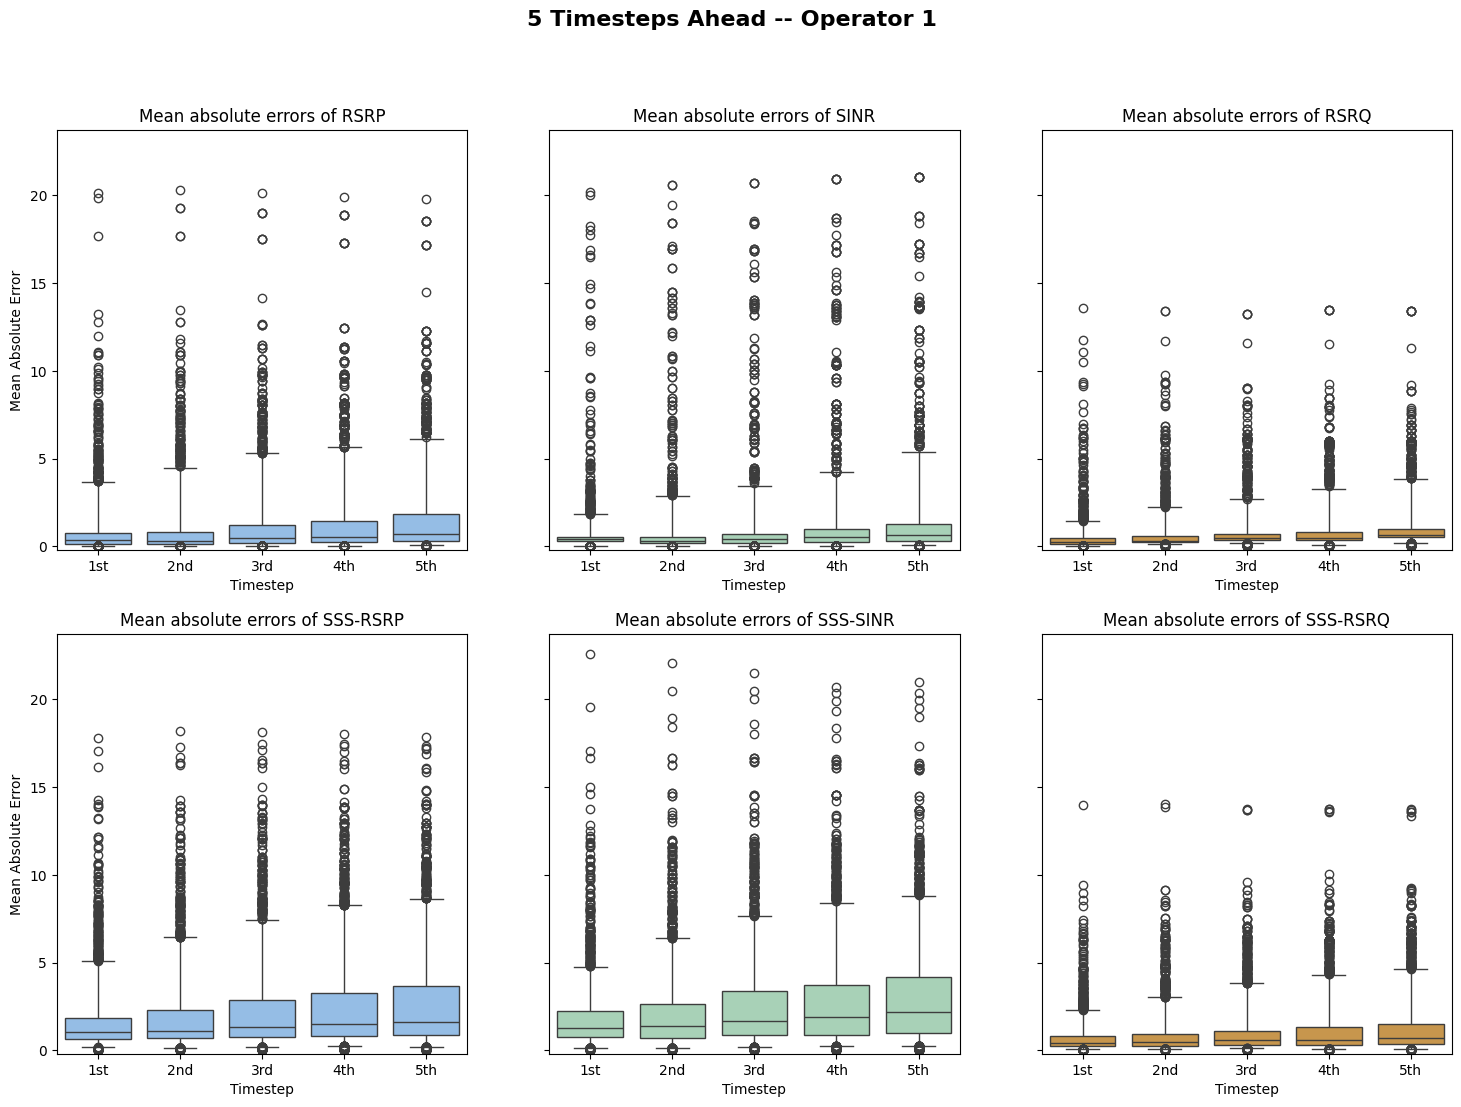

In [37]:
mae_each_step = boxplot_timesteps(results=lstm_results, feature_comb=feature_comb, sss_feature_comb=sss_feature_comb, n_steps_out=n_steps_out, operator=operator)

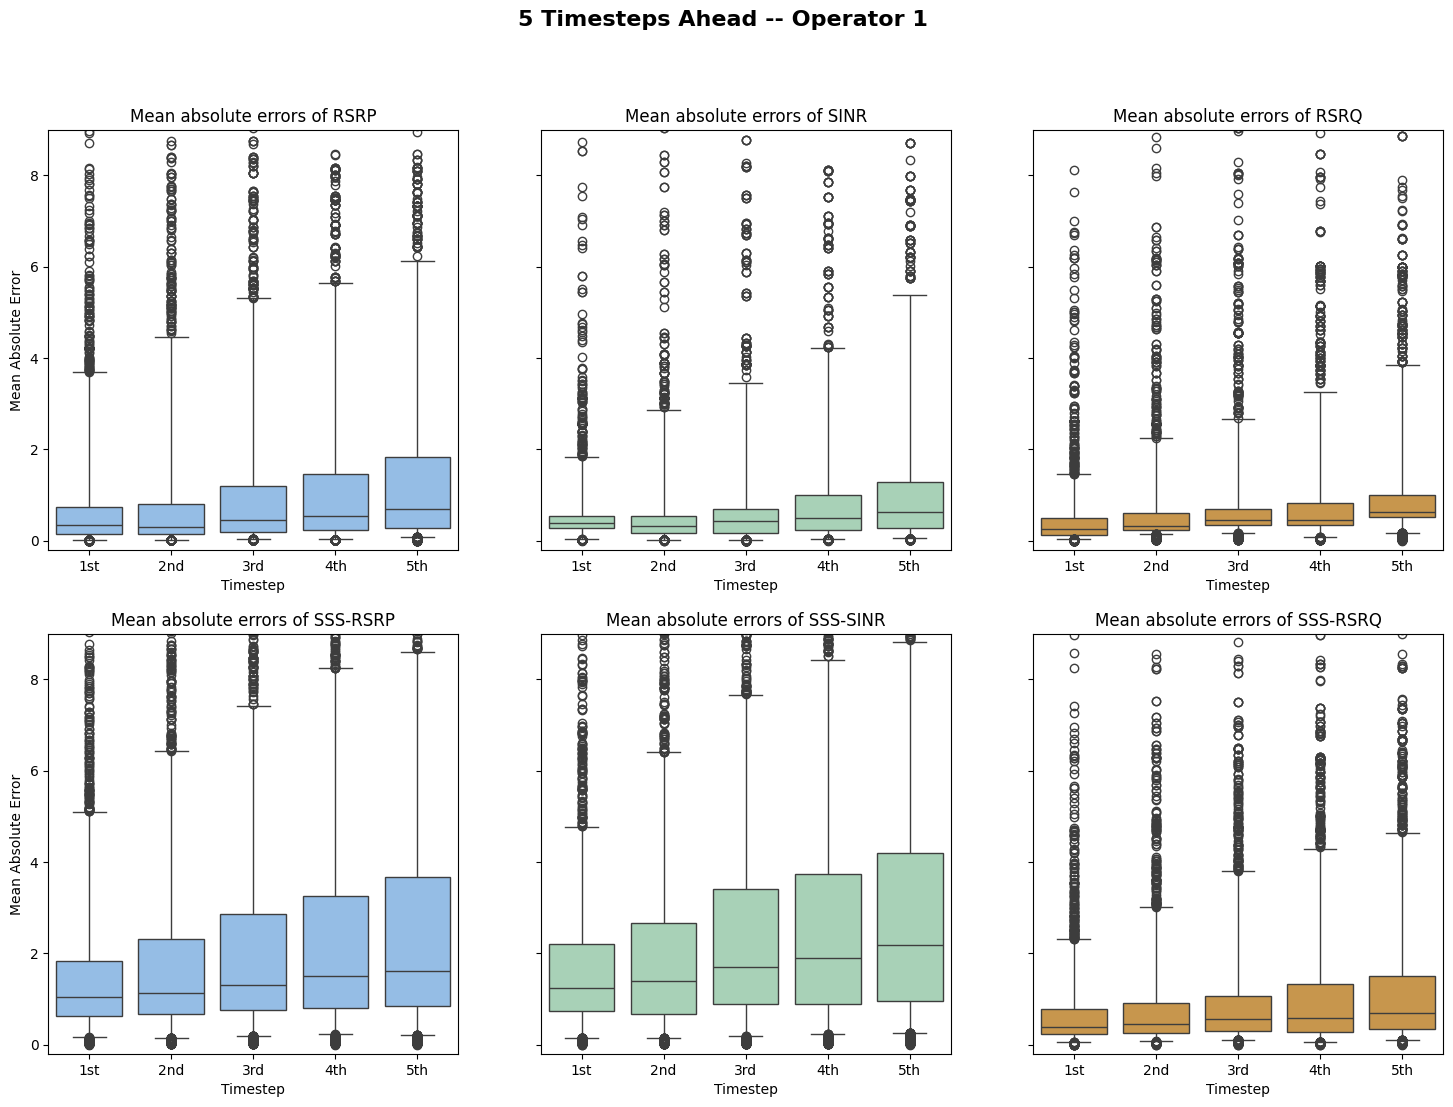

In [38]:
mae_each_step = boxplot_timesteps(results=lstm_results, feature_comb=feature_comb, sss_feature_comb=sss_feature_comb, n_steps_out=n_steps_out, operator=operator, y_lim=9)

In [39]:
mae_each_step

,1st,2nd,3rd,4th,5th
RSRP,0.807,0.949,1.176,1.346,1.542
SINR,0.644,0.752,0.963,1.190,1.389
RSRQ,0.480,0.631,0.807,0.871,1.062
SSS-RSRP,1.594,1.936,2.259,2.519,2.720
SSS-SINR,1.751,2.106,2.527,2.767,2.993
SSS-RSRQ,0.684,0.829,1.022,1.130,1.254


## 10 Steps Prediction

In [40]:
n_steps_in = 10
n_steps_out = 10

lstm_results = {}

for target in target_features:
    for features in feature_selection:
        if features.__contains__(target):
            used_features = ''
            if len(features) == 6:
                used_features = 'All'
            else:
                used_features = ', '.join(features)
            used_features = used_features + ' -> ' + target
            features.append('campaign')
            warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)
            lstm_results[used_features] = long_short_term_memory(train=train[features], test=test[features], target_feature=target, features=features, n_steps_in=n_steps_in, n_steps_out=n_steps_out, campaigns=train['campaign'].unique().tolist(), test_campaigns=test['campaign'].unique().tolist(), n_first_units=n_first_units, n_second_units=n_second_units)
            df_lstm_results = pd.DataFrame.from_dict(lstm_results, orient='index')

df_lstm_results.reset_index(inplace=True)
df_lstm_results.rename(columns={'index': 'Combination'}, inplace=True)
df_lstm_results = df_lstm_results.drop(['y_pred', 'y_true', 'train_pred', 'train_true', 'loss', 'val_loss', 'list_mae', 'train_list_mae'], axis=1)
df_lstm_results

,Combination,loss_final,val_loss_final,mae,train_mae
0,"RSRP, SINR, RSRQ -> RSRP",0.00747,0.00785,1.49,2.20
1,All -> RSRP,0.00695,0.01181,1.76,2.45
2,"RSRP, SINR, RSRQ -> SINR",0.00598,0.00562,1.54,2.28
3,All -> SINR,0.00527,0.00881,1.84,2.47
4,"RSRP, SINR, RSRQ -> RSRQ",0.01287,0.00501,0.86,1.04
5,All -> RSRQ,0.01172,0.00524,0.98,1.04
6,"SSS_RSRP, SSS_SINR, SSS_RSRQ -> SSS_RSRP",0.00492,0.00329,2.57,2.19
7,All -> SSS_RSRP,0.00475,0.00419,2.83,2.37
8,"SSS_RSRP, SSS_SINR, SSS_RSRQ -> SSS_SINR",0.00658,0.00591,2.84,2.45
9,All -> SSS_SINR,0.00613,0.00591,3.01,2.42


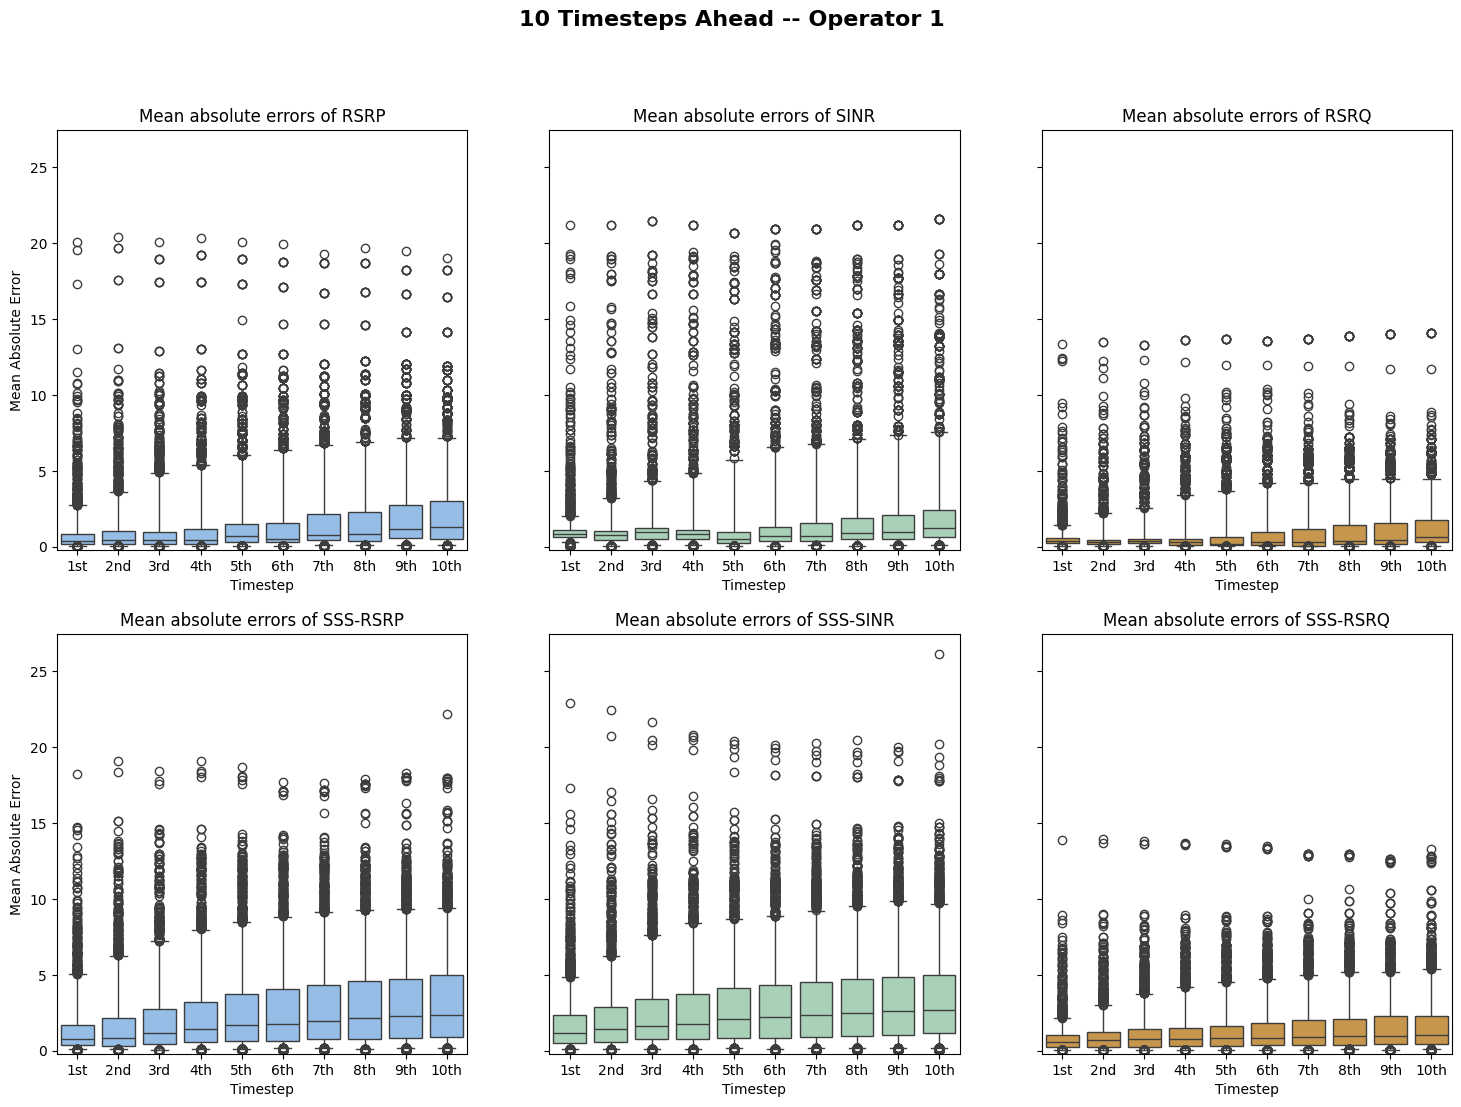

In [41]:
mae_each_step = boxplot_timesteps(results=lstm_results, feature_comb=feature_comb, sss_feature_comb=sss_feature_comb, n_steps_out=n_steps_out, operator=operator)

In [42]:
mae_each_step

,1st,2nd,3rd,4th,5th,6th,7th,8th,9th,10th
RSRP,0.730,0.943,1.062,1.192,1.463,1.518,1.753,1.870,2.135,2.232
SINR,1.056,1.103,1.339,1.379,1.300,1.540,1.661,1.885,1.985,2.197
RSRQ,0.548,0.562,0.685,0.719,0.767,0.897,0.951,1.060,1.138,1.270
SSS-RSRP,1.416,1.698,2.090,2.365,2.640,2.791,2.980,3.100,3.230,3.344
SSS-SINR,1.710,2.090,2.442,2.658,2.888,3.056,3.202,3.330,3.468,3.551
SSS-RSRQ,0.778,0.969,1.115,1.220,1.297,1.383,1.476,1.533,1.627,1.660


In [43]:
n_steps_in = 20
n_steps_out = 10

lstm_results = {}

for target in target_features:
    for features in feature_selection:
        if features.__contains__(target):
            used_features = ''
            if len(features) == 6:
                used_features = 'All'
            else:
                used_features = ', '.join(features)
            used_features = used_features + ' -> ' + target
            features.append('campaign')
            warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)
            lstm_results[used_features] = long_short_term_memory(train=train[features], test=test[features], target_feature=target, features=features, n_steps_in=n_steps_in, n_steps_out=n_steps_out, campaigns=train['campaign'].unique().tolist(), test_campaigns=test['campaign'].unique().tolist(), n_first_units=n_first_units, n_second_units=n_second_units)
            df_lstm_results = pd.DataFrame.from_dict(lstm_results, orient='index')

df_lstm_results.reset_index(inplace=True)
df_lstm_results.rename(columns={'index': 'Combination'}, inplace=True)
df_lstm_results = df_lstm_results.drop(['y_pred', 'y_true', 'train_pred', 'train_true', 'loss', 'val_loss', 'list_mae', 'train_list_mae'], axis=1)
df_lstm_results

,Combination,loss_final,val_loss_final,mae,train_mae
0,"RSRP, SINR, RSRQ -> RSRP",0.00687,0.00835,1.51,2.15
1,All -> RSRP,0.00599,0.01501,2.23,2.58
2,"RSRP, SINR, RSRQ -> SINR",0.01531,0.05128,3.90,5.49
3,All -> SINR,0.00467,0.00602,2.29,2.46
4,"RSRP, SINR, RSRQ -> RSRQ",0.01207,0.00825,1.47,1.39
5,All -> RSRQ,0.00869,0.00533,1.33,0.96
6,"SSS_RSRP, SSS_SINR, SSS_RSRQ -> SSS_RSRP",0.00472,0.00419,2.73,2.28
7,All -> SSS_RSRP,0.00454,0.00401,2.96,2.25
8,"SSS_RSRP, SSS_SINR, SSS_RSRQ -> SSS_SINR",0.00644,0.00619,2.82,2.44
9,All -> SSS_SINR,0.00600,0.00555,2.95,2.35


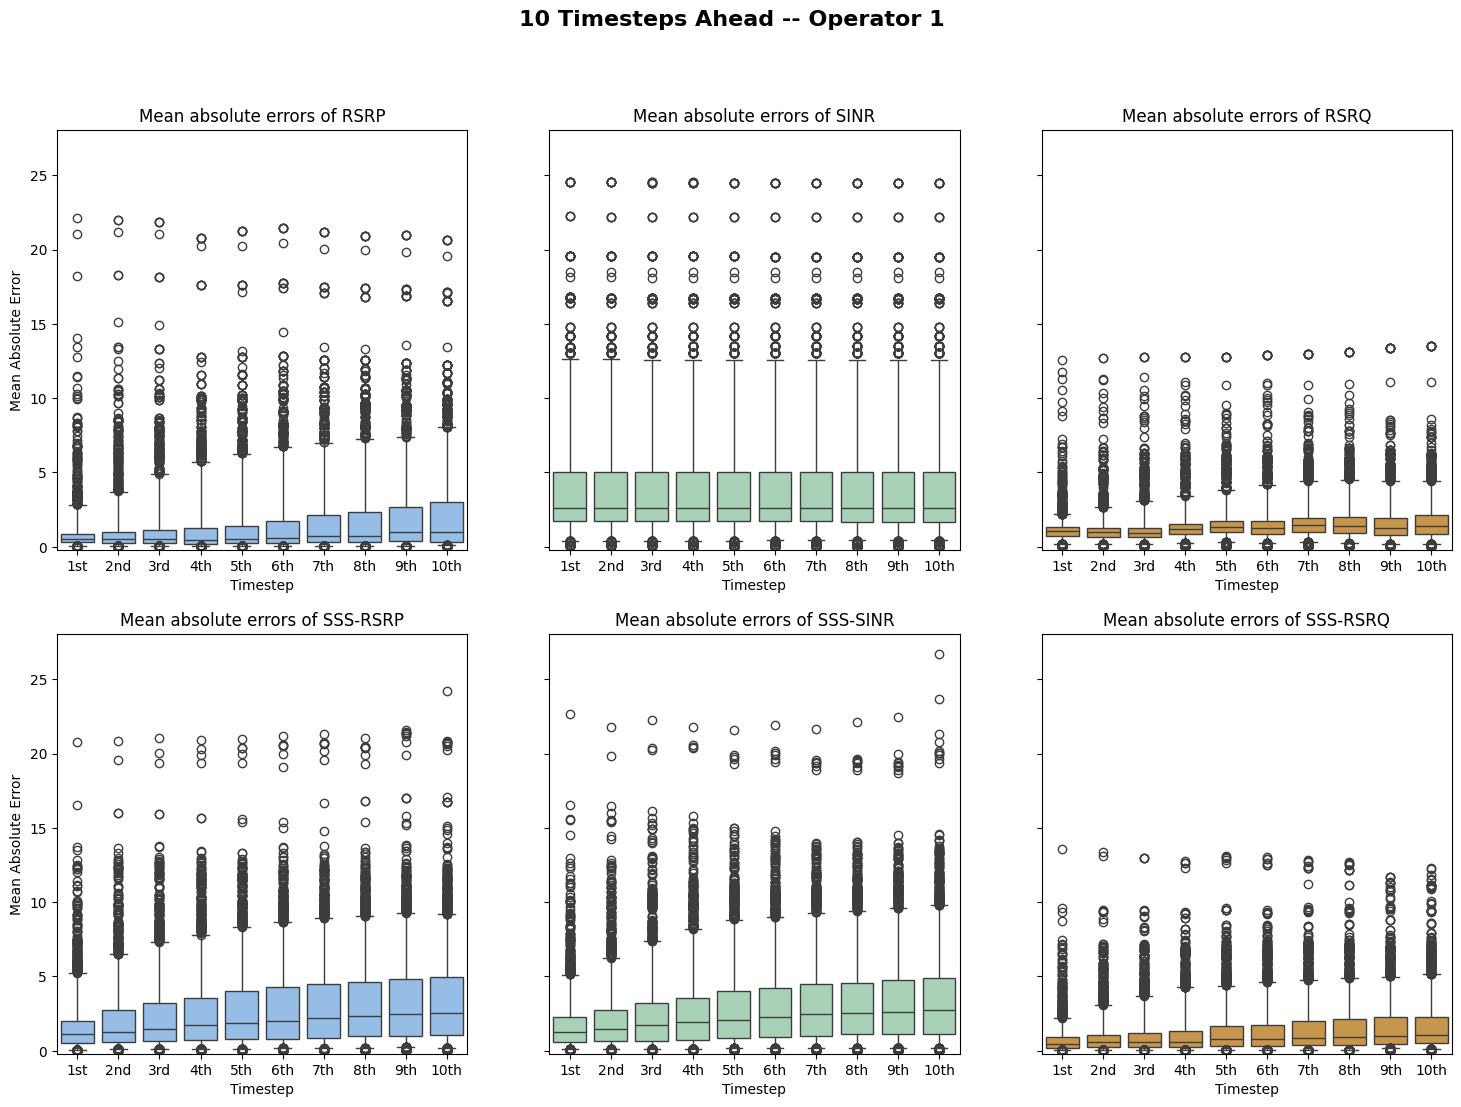

In [44]:
mae_each_step = boxplot_timesteps(results=lstm_results, feature_comb=feature_comb, sss_feature_comb=sss_feature_comb, n_steps_out=n_steps_out, operator=operator)

In [45]:
mae_each_step

,1st,2nd,3rd,4th,5th,6th,7th,8th,9th,10th
RSRP,0.847,1.024,1.158,1.263,1.404,1.605,1.756,1.854,2.055,2.149
SINR,3.903,3.902,3.900,3.898,3.898,3.896,3.896,3.893,3.894,3.894
RSRQ,1.128,1.131,1.172,1.402,1.579,1.555,1.701,1.691,1.622,1.708
SSS-RSRP,1.641,2.049,2.329,2.551,2.758,2.931,3.076,3.214,3.338,3.421
SSS-SINR,1.711,2.081,2.378,2.637,2.876,3.046,3.220,3.330,3.435,3.528
SSS-RSRQ,0.725,0.914,1.030,1.119,1.302,1.349,1.454,1.521,1.612,1.680


In [46]:
n_steps_in = 30
n_steps_out = 10

lstm_results = {}

for target in target_features:
    for features in feature_selection:
        if features.__contains__(target):
            used_features = ''
            if len(features) == 6:
                used_features = 'All'
            else:
                used_features = ', '.join(features)
            used_features = used_features + ' -> ' + target
            features.append('campaign')
            warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)
            lstm_results[used_features] = long_short_term_memory(train=train[features], test=test[features], target_feature=target, features=features, n_steps_in=n_steps_in, n_steps_out=n_steps_out, campaigns=train['campaign'].unique().tolist(), test_campaigns=test['campaign'].unique().tolist(), n_first_units=n_first_units, n_second_units=n_second_units)
            df_lstm_results = pd.DataFrame.from_dict(lstm_results, orient='index')

df_lstm_results.reset_index(inplace=True)
df_lstm_results.rename(columns={'index': 'Combination'}, inplace=True)
df_lstm_results = df_lstm_results.drop(['y_pred', 'y_true', 'train_pred', 'train_true', 'loss', 'val_loss', 'list_mae', 'train_list_mae'], axis=1)
df_lstm_results

,Combination,loss_final,val_loss_final,mae,train_mae
0,"RSRP, SINR, RSRQ -> RSRP",0.00607,0.01196,2.08,2.47
1,All -> RSRP,0.00594,0.02435,2.18,2.80
2,"RSRP, SINR, RSRQ -> SINR",0.00371,0.02334,2.33,2.76
3,All -> SINR,0.00510,0.01597,1.82,2.69
4,"RSRP, SINR, RSRQ -> RSRQ",0.01089,0.00561,0.94,0.99
5,All -> RSRQ,0.00932,0.00554,1.16,1.01
6,"SSS_RSRP, SSS_SINR, SSS_RSRQ -> SSS_RSRP",0.00501,0.00420,2.79,2.32
7,All -> SSS_RSRP,0.00459,0.00334,2.99,2.24
8,"SSS_RSRP, SSS_SINR, SSS_RSRQ -> SSS_SINR",0.00651,0.00713,2.80,2.48
9,All -> SSS_SINR,0.00560,0.00679,3.07,2.40


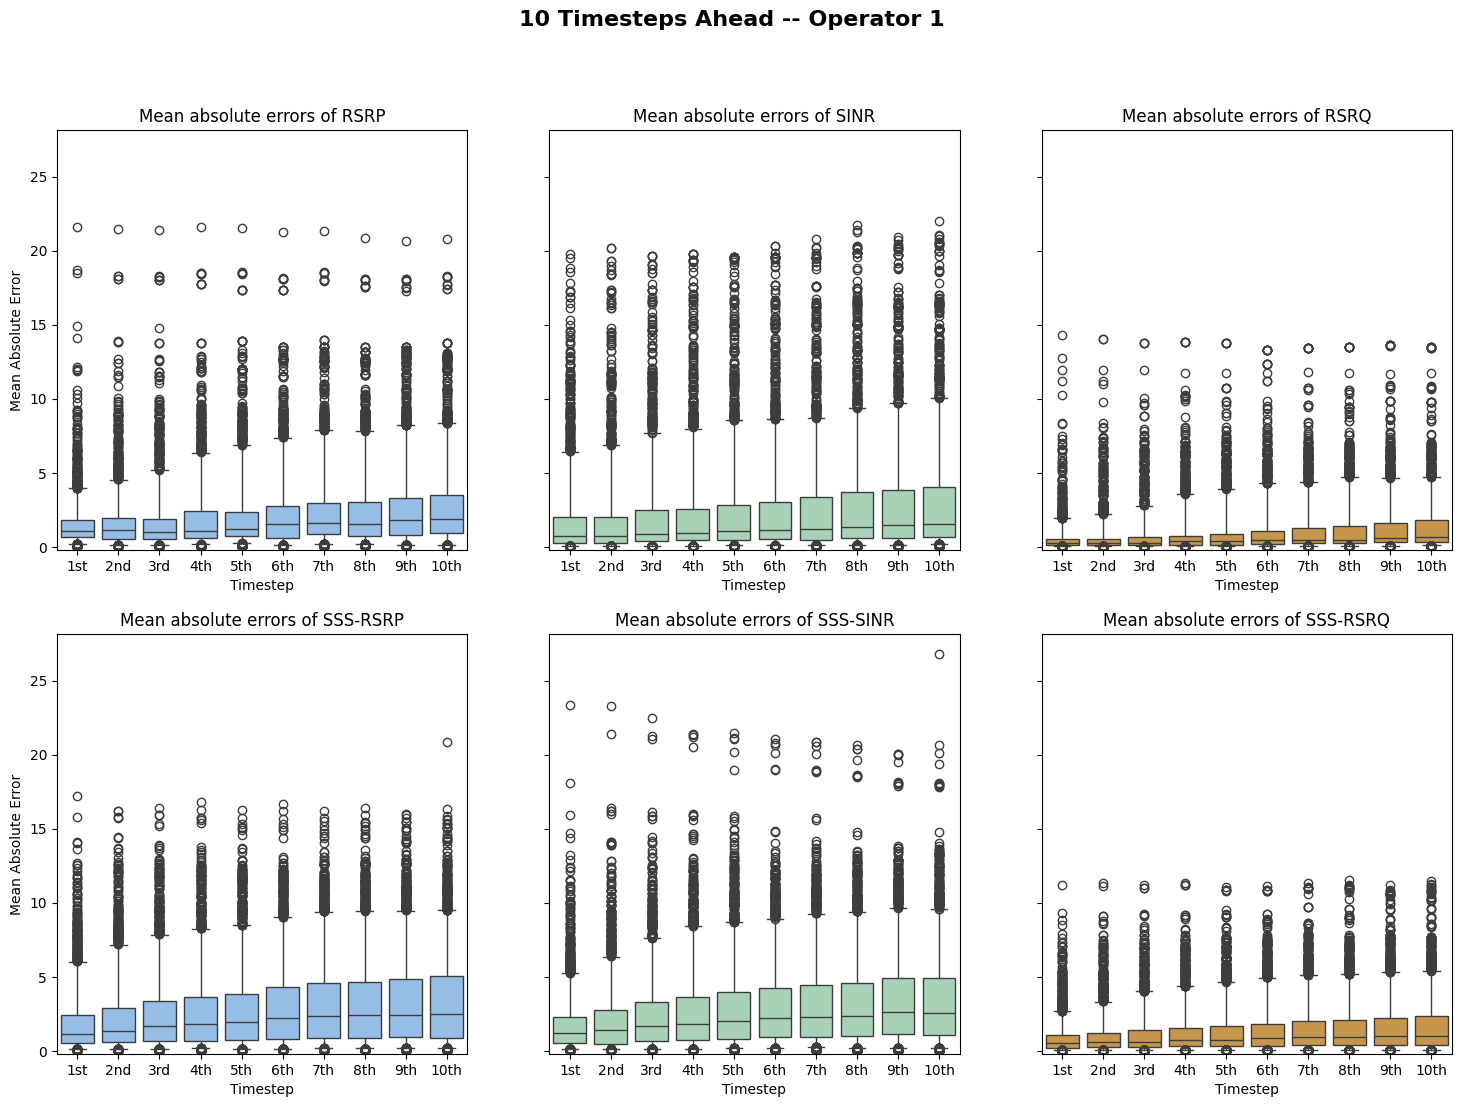

In [47]:
mae_each_step = boxplot_timesteps(results=lstm_results, feature_comb=feature_comb, sss_feature_comb=sss_feature_comb, n_steps_out=n_steps_out, operator=operator)

In [48]:
mae_each_step

,1st,2nd,3rd,4th,5th,6th,7th,8th,9th,10th
RSRP,1.463,1.581,1.585,1.888,2.002,2.188,2.391,2.376,2.612,2.731
SINR,1.709,1.747,2.026,2.124,2.283,2.404,2.520,2.741,2.818,2.928
RSRQ,0.520,0.575,0.677,0.814,0.897,1.038,1.076,1.176,1.280,1.355
SSS-RSRP,1.827,2.144,2.465,2.626,2.809,2.974,3.137,3.229,3.334,3.401
SSS-SINR,1.759,2.057,2.404,2.617,2.870,3.036,3.149,3.248,3.435,3.445
SSS-RSRQ,0.854,0.981,1.102,1.221,1.315,1.406,1.492,1.557,1.607,1.645


In [49]:
n_steps_in = 40
n_steps_out = 10

lstm_results = {}

for target in target_features:
    for features in feature_selection:
        if features.__contains__(target):
            used_features = ''
            if len(features) == 6:
                used_features = 'All'
            else:
                used_features = ', '.join(features)
            used_features = used_features + ' -> ' + target
            features.append('campaign')
            warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)
            lstm_results[used_features] = long_short_term_memory(train=train[features], test=test[features], target_feature=target, features=features, n_steps_in=n_steps_in, n_steps_out=n_steps_out, campaigns=train['campaign'].unique().tolist(), test_campaigns=test['campaign'].unique().tolist(), n_first_units=n_first_units, n_second_units=n_second_units)
            df_lstm_results = pd.DataFrame.from_dict(lstm_results, orient='index')

df_lstm_results.reset_index(inplace=True)
df_lstm_results.rename(columns={'index': 'Combination'}, inplace=True)
df_lstm_results = df_lstm_results.drop(['y_pred', 'y_true', 'train_pred', 'train_true', 'loss', 'val_loss', 'list_mae', 'train_list_mae'], axis=1)
df_lstm_results

,Combination,loss_final,val_loss_final,mae,train_mae
0,"RSRP, SINR, RSRQ -> RSRP",0.00616,0.01950,2.00,2.63
1,All -> RSRP,0.00557,0.02000,2.62,2.77
2,"RSRP, SINR, RSRQ -> SINR",0.00518,0.01941,1.83,2.68
3,All -> SINR,0.00398,0.01525,3.63,2.89
4,"RSRP, SINR, RSRQ -> RSRQ",0.00919,0.00547,1.18,0.98
5,All -> RSRQ,0.00937,0.01024,1.19,1.04
6,"SSS_RSRP, SSS_SINR, SSS_RSRQ -> SSS_RSRP",0.00480,0.00350,2.84,2.33
7,All -> SSS_RSRP,0.00428,0.00742,3.19,2.47
8,"SSS_RSRP, SSS_SINR, SSS_RSRQ -> SSS_SINR",0.00647,0.00570,2.78,2.38
9,All -> SSS_SINR,0.00505,0.00940,3.61,2.41


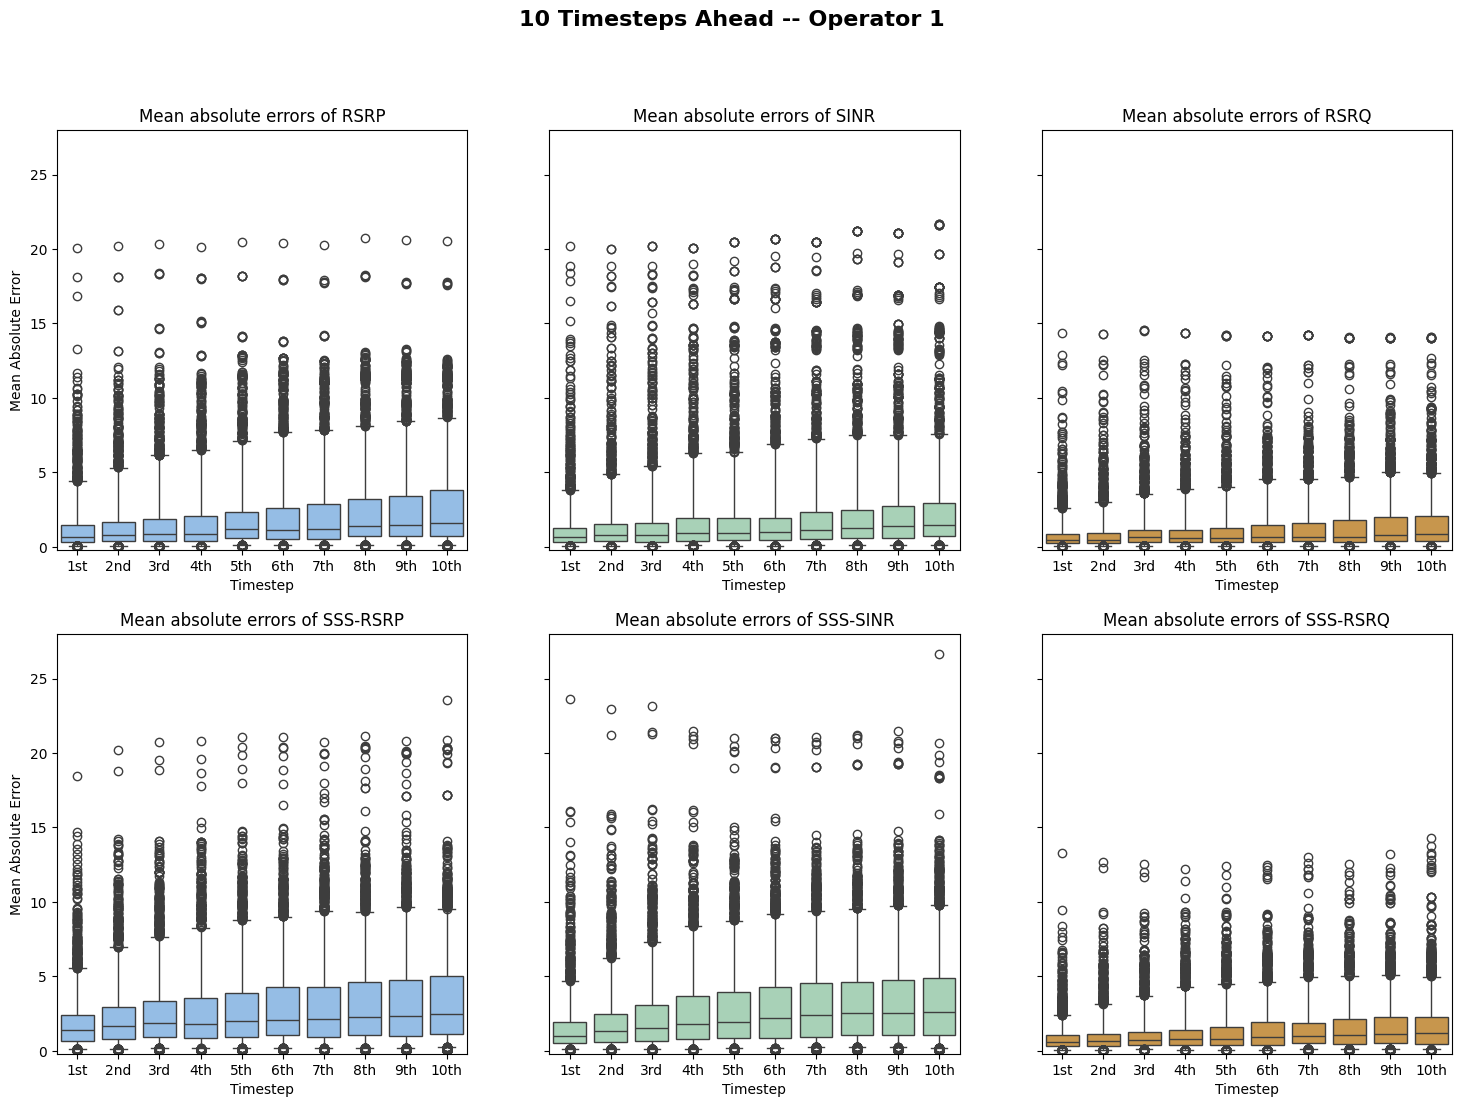

In [50]:
mae_each_step = boxplot_timesteps(results=lstm_results, feature_comb=feature_comb, sss_feature_comb=sss_feature_comb, n_steps_out=n_steps_out, operator=operator)

In [51]:
mae_each_step

,1st,2nd,3rd,4th,5th,6th,7th,8th,9th,10th
RSRP,1.245,1.440,1.614,1.718,2.010,2.109,2.212,2.428,2.559,2.670
SINR,1.165,1.397,1.475,1.736,1.778,1.856,2.076,2.133,2.284,2.386
RSRQ,0.792,0.876,1.055,1.072,1.127,1.234,1.310,1.347,1.460,1.528
SSS-RSRP,1.885,2.293,2.533,2.631,2.870,3.058,3.118,3.263,3.313,3.440
SSS-SINR,1.536,1.950,2.313,2.629,2.834,3.057,3.229,3.352,3.417,3.490
SSS-RSRQ,0.839,0.952,1.112,1.209,1.302,1.436,1.510,1.568,1.641,1.683
